# Libraries

In [3]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

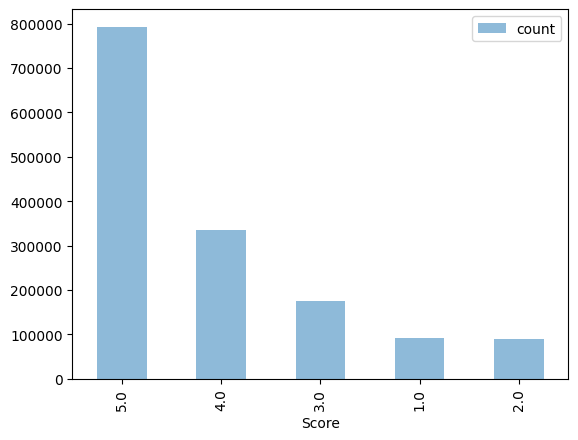


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [4]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)

plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")


# Adding Features

In [5]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    for col in ['Text', 'Summary']:
        df[col] = df[col].fillna('')

    df['Text_length'] = df['Text'].str.len()
    df['Summary_length'] = df['Summary'].str.len()
    df['Text_word_count'] = df['Text'].str.split().apply(len)
    df['Summary_word_count'] = df['Summary'].str.split().apply(len)
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
    
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, on='Id', how='right')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

for dataset in [X_train, X_submission]:
    dataset['Text'] = dataset['Text'].fillna('')

print("Vectorizing")
text_vector = TfidfVectorizer(max_features=5000)
X_train_tfidf = text_vector.fit_transform(X_train['Text'])
X_submission_tfidf = text_vector.transform(X_submission['Text'])

print("Truncated SVD")
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_submission_text_svd = svd.transform(X_submission_tfidf)

Vectorizing
Truncated SVD


# Feature Selection

In [6]:
features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness',
    'Text_length', 'Summary_length', 'Text_word_count', 'Summary_word_count'
]

X_train_data = X_train[features].values
X_submission_data = X_submission[features].values

print("Combining features...")
X_train_final = np.hstack([X_train_data, X_train_svd])
X_submission_final = np.hstack([X_submission_data, X_submission_text_svd])

Y_train = X_train['Score']

print("Splitting data into training and validation sets...")
X_train, X_split, Y_train_split, Y_test = train_test_split(
    X_train_final, Y_train, test_size=0.25, random_state=42
)

Combining features...
Splitting data into training and validation sets...


# Model Creation

In [7]:
random_forest = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42,
    n_jobs=-1
)

xgboost = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.05,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

stacking_model = StackingClassifier(
    estimators=[('rf', random_forest), ('xgb', xgboost)],
    final_estimator=LogisticRegression(max_iter=500),
    cv=5
)

stacking_model.fit(X_train, Y_train_split)
Y_test_predictions = stacking_model.predict(X_split)

# Model Evaluation

Accuracy on testing set =  0.5992874377921882


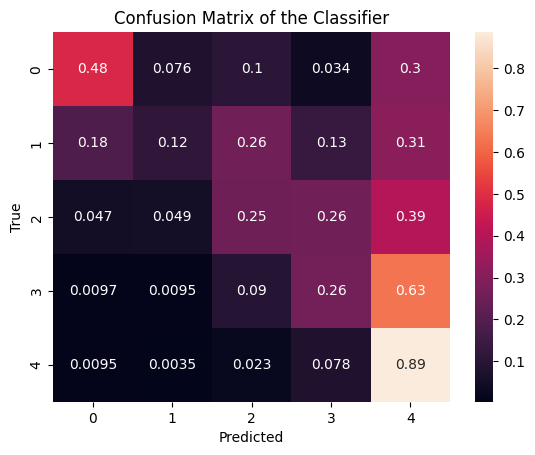

In [8]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Create submission file

In [9]:
# Create submission file
X_submission['Score'] = stacking_model.predict(X_submission_final)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)